### Compute and store filtered and demodulated velocity fields at each grid point

In [1]:
import numpy as np
import geopandas as gpd

import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from xhistogram.xarray import histogram
import dask.dataframe as dd
#import cartopy.crs as ccrs
#import cartopy.feature as cfeature

import mitequinox.utils as ut
from mitequinox.plot import *
import mitequinox.parcels as pa
from xmitgcm import llcreader

from scipy import signal
import scipy.ndimage as im

from sympy import Symbol, pi, atan, factor, lambdify


import mitequinox.plot as pl
import mitequinox.sigp as sp

from fsspec.implementations.local import LocalFileSystem

In [2]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
cluster = PBSCluster(processes=7, cores=7,walltime='04:00:00') #processes=7, cores=7
w = cluster.scale(jobs=10
                 )
client = Client(cluster)

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [3]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.0.245:8787/status,
Dashboard: http://10.148.0.245:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.0.245:47793,Workers: 0
Dashboard: http://10.148.0.245:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [4]:
def convolve(x, h=None, hilbert=False):
    """ Convolve an input signal with a kernel
    Optionaly compute the Hilbert transform of the resulting time series
    
    Parameters
    x : input signal
    h : filter 
    hilbert : True for Hilbert transform to be applied to the filtered signal
    
    Returns
    x_f : filtered signal or hilbert transform of the filtered signal
    """
    x_f = signal.filtfilt(h, [1], x, axis=-1,padlen=0)#
    if hilbert:
        return signal.hilbert(x_f)
    else:
        return x_f

def filt(v, h, hilbert=False):
    
    output_dtype = complex if hilbert else float
    gufunc_kwargs = dict(output_sizes={'time': len(v.time)})
    return xr.apply_ufunc(convolve, v, kwargs={'h': h, 'hilbert': hilbert},
                    dask='parallelized', output_dtypes=[output_dtype],
                    input_core_dims=[['time']],
                    output_core_dims=[['time']],
                    dask_gufunc_kwargs = gufunc_kwargs,
                         )

##### First step : Filter and demodulate for each face

In [19]:
# Load Eulerian fields
ds =  xr.open_zarr(ut.work_data_dir+'rechunked/Eta_2dij.zarr')
grd = ut.load_grd(consolidated=False)[['XC', 'YC', 'Depth']]#.persist()

/dev/shm/pbs.45151.datarmor0/ipykernel_34852/3584522092.py:2: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  ds =  xr.open_zarr(ut.work_data_dir+'rechunked/Eta_2dij.zarr')


In [9]:
ds

,Array,Chunk
Bytes,1.94 TiB,115.80 MiB
Shape,"(8784, 13, 2160, 2160)","(2196, 1, 96, 144)"
Count,17941 Tasks,17940 Chunks
Type,float32,numpy.ndarray


In [20]:
#isel=dict(face=12) #face
#V = ['SSV_rot']#'zonal_velocity','meridional_velocity'
path = '/home1/datawork/zcaspar/mit4320/filtered_itide/'
dsel = 200

In [21]:
dt = 1/24 # time step in days

tidal_omega = sp.get_tidal_frequencies("M2", "K2","S2","N2")
omega_M2,omega_S2,omega_N2,omega_K2, domega, name = tidal_omega["M2"],tidal_omega["S2"],tidal_omega["N2"],tidal_omega["K2"], .2, "semidiurnal"
omega = (omega_M2+omega_S2)/2#center frequency
Tw = 30 #filter length
dband = 0.2 # half-bandwidth
V = ['Eta']

In [22]:
#dt = 1. # in hours
#T = 20
#omega = 1/30
#h = signal.firwin(T*24, cutoff=[omega], pass_zero=True, nyq=1./2/dt, scale=True)
#V = 'SSU_rot'

In [23]:
import dask
om,Tw,dband,V = omega,Tw,dband,V #define parameters needed in wrap_filter
h = sp.generate_filter(om, T=Tw, dt=dt, bandwidth=dband, normalized_bandwidth=None)
def wrap_filter(_ds,dt=dt):
    time = np.arange(0,_ds['time'].values.size*dt,dt)
    exp = np.exp(-1j*om*2*np.pi*time)
#    _ds = ut._reset_chunk_encoding(_ds)
#    _ds = _ds.chunk(dict(time=-1,i=100,j=100))
    ds_hat={}
    for v in V:
        ds_hat[v+'_hat'] = filt(_ds[v], h,hilbert=True)#.persist()
        ds_hat[v+'_hat_real'] = ds_hat[v+'_hat'].real
        ds_hat[v+'_hat_imag'] = ds_hat[v+'_hat'].imag
#        ds_hat[v+'_hat'] = ds_hat[v+'_hat'].assign_coords({'lon':ds_hat[v+'_hat'].lon,'lat':ds_hat[v+'_hat'].lat})
        ds_hat[v+'_demodulated'] = ds_hat[v+'_hat']*exp
        ds_hat[v+'_demodulated_real'] = ds_hat[v+'_demodulated'].real
        ds_hat[v+'_demodulated_imag'] = ds_hat[v+'_demodulated'].imag
    ds_hat = xr.merge([ds_hat[v].rename(v) for v in ds_hat.keys()])#.drop([v+'_hat',v+'_demodulated'])
#    ds_hat = ds_hat.chunk(dict(i=100)) #,j=4320//4
    ds_hat = ut._reset_chunk_encoding(ds_hat)
    return ds_hat#.drop(['XC','YC'])

def wrap_filter_low(_ds,dt=dt):
    h = signal.firwin(T*24, cutoff=[omega], pass_zero=True, nyq=1./2/dt, scale=True)
    ds_hat = filt(_ds[v], h,hilbert=False)#.persist()
    ds_hat = ds_hat.rename(v+'_hat').to_dataset()
#    ds_hat = ds_hat.chunk(dict(i=4320//4,j=4320//4))
#    ds_hat = ut._reset_chunk_encoding(ds_hat)
    return ds_hat

In [24]:
def wrap_demodulation(ds_hat,dt=dt):
#    time = np.arange(0,ds_hat['time'].values.size*dt,dt)
    exp = np.exp(-1j*om*2*np.pi*time)

#    _ds = ut._reset_chunk_encoding(_ds)
#    _ds = _ds.chunk(dict(time=16,i=100,j=100))
#    ds_hat={}
    for v in V:
#        ds_hat[v+'_hat'] = ds_hat[v+'_hat_real']+1j*ds_hat[v+'_hat_imag']
#        ds_hat[v+'_hat'] = ds_hat[v+'_hat'].assign_coords({'lon':ds_hat[v+'_hat'].lon,'lat':ds_hat[v+'_hat'].lat})
        ds_hat[v+'_demodulated'] = ds_hat[v+'_hat']*exp
        ds_hat[v+'_demodulated_real'] = ds_hat[v+'_demodulated'].real
        ds_hat[v+'_demodulated_imag'] = ds_hat[v+'_demodulated'].imag
    ds_hat = xr.merge([ds_hat[v].rename(v) for v in ds_hat.keys()]).drop([v+'_demodulated',v+'_hat'])
 #   ds_hat = ds_hat.chunk(dict(i=100)) #,j=4320//4
    
    return ds_hat#.drop(['XC','YC'])

In [25]:
#Select and rechunk (empirical) original dataset
isel = dict(i=slice(0,None,2),j=slice(0,None,2),time=slice(0,None,3))#dict(j=slice(3800,None))#j=slice(0,4320//10))
#dsp = ds.sel(j=slice(0,1000))
dsp = ds.isel(**isel)#.sel(i=slice(0,None,4),j=slice(0,None,4))#j=slice(0,1000))
#.isel(i=slice(4,None,4),j=slice(4, None,4))#.isel(face=0)#.sel(**sel)#.persist()
dsp = dsp.chunk({"time": -1})#.persist()#,'i':100,'j':70
dsp

,Array,Chunk
Bytes,165.39 GiB,38.60 MiB
Shape,"(2928, 13, 1080, 1080)","(2928, 1, 48, 72)"
Count,40366 Tasks,4485 Chunks
Type,float32,numpy.ndarray


In [30]:
dsp =  xr.open_zarr(ut.work_data_dir+'filtered_itide/SSU_demodulated.zarr',consolidated=False)#.isel(face=slice(1,None))
dsp = dsp.drop(['SSU_rot_demodulated_real','SSU_rot_demodulated_imag'])
dsp['SSU_rot_hat'] = dsp['SSU_rot_hat_real']+1j*dsp['SSU_rot_hat_imag']

In [28]:
time = np.arange(0,dsp['time'].values.size*dt,dt)
time

array([0.00000000e+00, 4.16666667e-02, 8.33333333e-02, ...,
       3.59875000e+02, 3.59916667e+02, 3.59958333e+02])

In [42]:
dsp_cov =  xr.open_zarr(ut.work_data_dir+'filtered_itide/SSU_autocov.zarr',consolidated=False)#.isel(face=slice(1,None))

In [44]:
dsp_cov

<xarray.Dataset>
Dimensions:  ()
Data variables:
    *empty*

In [26]:
# Apply wrap_filter on the dataset and store the result for each face (seperated)
import os
#zarr_main = os.path.join(ut.root_data_dir, "filtered_itide/SSU_filtered_face4.zarr")
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ds_out, zarr = ut.custom_distribute(dsp, 
                                        wrap_filter,
                                        overwrite=True,
                                        suffix="Eta_filtered.zarr",
                                        tmp_dir=os.path.join(ut.root_data_dir, "filtered_itide"),
                                        append=True,
                                        face=1
#                                        j=100
                                       )

13it [08:07, 37.49s/it]


In [38]:
ds_out

,Array,Chunk
Bytes,2.35 TiB,26.37 MiB
Shape,"(4320, 4320, 8640)","(100, 1080, 16)"
Count,95041 Tasks,95040 Chunks
Type,complex128,numpy.ndarray
,Array,Chunk
Bytes,2.35 TiB,26.37 MiB
Shape,"(4320, 4320, 8640)","(100, 1080, 16)"
Count,95041 Tasks,95040 Chunks
Type,complex128,numpy.ndarray


In [13]:
ds_out

,Array,Chunk
Bytes,11.73 TiB,1.29 GiB
Shape,"(5, 4320, 4320, 8640)","(1, 100, 100, 8640)"
Count,9681 Tasks,9680 Chunks
Type,complex128,numpy.ndarray
,Array,Chunk
Bytes,5.87 TiB,659.18 MiB
Shape,"(5, 4320, 4320, 8640)","(1, 100, 100, 8640)"
Count,9681 Tasks,9680 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


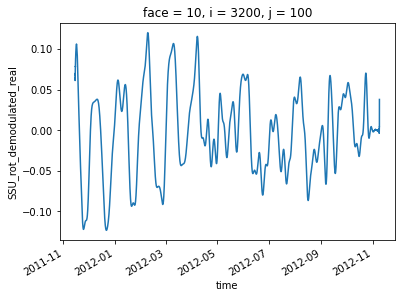

In [113]:
ds_out.isel(face=0).sel(i=3200,j=100).SSU_rot_demodulated_real.plot()

In [14]:
#client.restart()
#
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


##### Second step : Concat filtered and demodulated fields

In [41]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()

#
from dask_jobqueue import PBSCluster
cluster = PBSCluster(processes=7, cores=7, walltime='04:00:00') #processes=7, cores=7 ,walltime='03:00:00'
w = cluster.scale(jobs=8
                 )
client = Client(cluster)

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 52200 instead
  warnings.warn(


In [42]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.1.69:52200/status,
Dashboard: http://10.148.1.69:52200/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.1.69:54125,Workers: 0
Dashboard: http://10.148.1.69:52200/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [43]:
#ds = xr.concat([xr.open_zarr(ut.work_data_dir+'filtered_itide/SSU_band_filtered%s.zarr'%i, consolidated=False
#                            ) for i in ['','1','2']],dim = 'face')#.persist()
#ds
ds = xr.open_zarr(ut.work_data_dir+'filtered_itide/SSU_bandpassed_filtered.zarr')
ds

,Array,Chunk
Bytes,30.50 TiB,659.18 MiB
Shape,"(13, 4320, 4320, 8640)","(1, 50, 100, 8640)"
Count,49765 Tasks,49764 Chunks
Type,complex128,numpy.ndarray
,Array,Chunk
Bytes,15.25 TiB,329.59 MiB
Shape,"(13, 4320, 4320, 8640)","(1, 50, 100, 8640)"
Count,49765 Tasks,49764 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


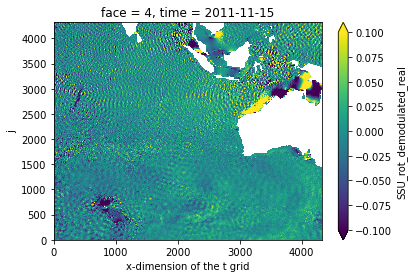

In [44]:
ds.SSU_rot_demodulated_real.isel(face=4,time=0).plot(cmap='viridis',vmax=0.1)

In [32]:
def merge(ds):
#    _ds = ds.chunk({'j':-1})
#
#    _ds = ds
    _ds = ds#.chunk(dict(i=4320//4,j=4320//4)) #,j=4320//4
    
    _ds = ut._reset_chunk_encoding(_ds)    
    return _ds

def residual(ds,V='SSU_rot_hat'):
    _ds = ds.copy()
    _ds[V+'_residual'] = _ds[V]-_ds[V].mean('time')
    _ds = ut._reset_chunk_encoding(_ds)
    return _ds

In [5]:
def rechunked(ds):
    _ds = ds.chunk({'i':4320//4}) #'time':16,
    _ds = ut._reset_chunk_encoding(_ds)    
    return _ds

In [12]:
ds.chunks

Frozen({'face': (1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1), 'j': (192, 192, 192, 192, 192, 40, 152, 152, 152, 152, 152, 152, 88, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 20), 'i': (100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 20), 'time': (8640,)})

In [13]:
ds = ds.isel(face=slice(8,None))
ds = ds.chunk({'time':-1,'j':100,'i':100})

In [26]:
ds

,Array,Chunk
Bytes,30.50 TiB,1.29 GiB
Shape,"(13, 4320, 4320, 8640)","(1, 100, 100, 8640)"
Count,50339 Tasks,25168 Chunks
Type,complex128,numpy.ndarray
,Array,Chunk
Bytes,15.25 TiB,659.18 MiB
Shape,"(13, 4320, 4320, 8640)","(1, 100, 100, 8640)"
Count,50339 Tasks,25168 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


In [7]:
ds = xr.open_zarr(ut.work_data_dir+'filtered_itide/SSU_low.zarr')
ds

,Array,Chunk
Bytes,0.95 TiB,455.62 MiB
Shape,"(13, 1080, 1080, 8640)","(1, 48, 144, 8640)"
Count,2393 Tasks,2392 Chunks
Type,float64,numpy.ndarray


In [33]:
#Apply concat function on ds
face = 1
import os, dask
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ds_out, zarr = ut.custom_distribute(ds,#xr.merge([ds0,ds1]), 
                                        merge,
                                        overwrite=True,
                                        suffix="SSU_bandpassed_filtered.zarr",
                                        tmp_dir=os.path.join(ut.root_data_dir, "filtered_itide"),
                                        append=True,
#                                        face=face
                                        j=50
                                        )

14it [24:06, 102.42s/it]tornado.application - ERROR - Uncaught exception GET /status (10.148.1.145)
HTTPServerRequest(protocol='http', host='localhost:8787', method='GET', uri='/status', version='HTTP/1.1', remote_ip='10.148.1.145')
Traceback (most recent call last):
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/tornado/web.py", line 1704, in _execute
    result = await result
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/bokeh/server/views/doc_handler.py", line 54, in get
    session = await self.get_session()
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/bokeh/server/views/session_handler.py", line 144, in get_session
    session = await self.application_context.create_session_if_needed(session_id, self.request, token)
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/bokeh/server/contexts.py", line 243, in create_session_if_needed
    self._appl

In [34]:
ds_out

,Array,Chunk
Bytes,30.50 TiB,659.18 MiB
Shape,"(13, 4320, 4320, 8640)","(1, 50, 100, 8640)"
Count,49765 Tasks,49764 Chunks
Type,complex128,numpy.ndarray
,Array,Chunk
Bytes,15.25 TiB,329.59 MiB
Shape,"(13, 4320, 4320, 8640)","(1, 50, 100, 8640)"
Count,49765 Tasks,49764 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


In [35]:
ds_out.SSU_rot_demodulated_real.isel(face=0,time=0).plot()

KeyboardInterrupt: 

In [19]:
ds_out = xr.concat([xr.open_zarr(ut.work_data_dir+'filtered_itide/SSU_demodulated_.zarr_%s'%i) for i in np.arange(0,8)],dim='face')
ds_out

,Array,Chunk
Bytes,9.39 TiB,659.18 MiB
Shape,"(8, 4320, 4320, 8640)","(1, 100, 100, 8640)"
Count,30984 Tasks,15488 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,9.39 TiB,659.18 MiB
Shape,"(8, 4320, 4320, 8640)","(1, 100, 100, 8640)"
Count,30984 Tasks,15488 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


In [21]:
_ds = xr.concat([xr.open_zarr(ut.work_data_dir+'filtered_itide/SSU_demodulated__.zarr_%s'%i) for i in np.arange(0,5)],dim='face')
ds_out = xr.concat([ds_out,_ds],dim='face')
ds_out

,Array,Chunk
Bytes,15.25 TiB,659.18 MiB
Shape,"(13, 4320, 4320, 8640)","(1, 100, 100, 8640)"
Count,75517 Tasks,25168 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,15.25 TiB,659.18 MiB
Shape,"(13, 4320, 4320, 8640)","(1, 100, 100, 8640)"
Count,75517 Tasks,25168 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


In [23]:
ds = xr.open_zarr(ut.work_data_dir+'filtered_itide/SSU_demodulated.zarr')
ds

,Array,Chunk
Bytes,15.25 TiB,659.18 MiB
Shape,"(13, 4320, 4320, 8640)","(1, 100, 100, 8640)"
Count,25169 Tasks,25168 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,15.25 TiB,659.18 MiB
Shape,"(13, 4320, 4320, 8640)","(1, 100, 100, 8640)"
Count,25169 Tasks,25168 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


In [14]:
ds = ds.chunk({'i':1080,'j':1080,'time':16})

In [24]:
def rechunking(ds):
    _ds = ds.chunk({'i':1080,'j':1080})#,'time':16
    _ds = ut._reset_chunk_encoding(_ds)    
    return _ds

In [25]:
#Apply concat function on ds
face = 1
import os, dask
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ds_out, zarr = ut.custom_distribute(ds,#xr.merge([ds0,ds1]), 
                                        rechunking,
                                        overwrite=True,
                                        suffix="SSU_rechunked.zarr",
                                        tmp_dir=os.path.join(ut.root_data_dir, "filtered_itide"),
                                        append=True,
                                        face=face
#                                        j=50
                                        )

0it [01:40, ?it/s]


OSError: [Errno 12] Cannot allocate memory

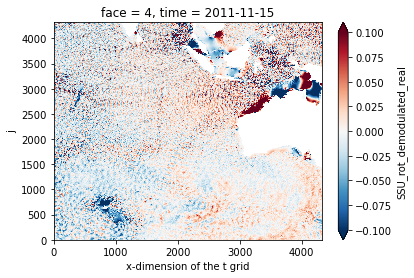

In [24]:
ds_out.SSU_rot_demodulated_real.isel(face=4,time=0).plot(vmax=0.1)

In [25]:
ds_out

,Array,Chunk
Bytes,15.25 TiB,659.18 MiB
Shape,"(13, 4320, 4320, 8640)","(1, 100, 100, 8640)"
Count,25169 Tasks,25168 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,15.25 TiB,659.18 MiB
Shape,"(13, 4320, 4320, 8640)","(1, 100, 100, 8640)"
Count,25169 Tasks,25168 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


In [27]:
#client.restart()
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
